LSA - Латентно-семантический анализ

**Латентно-семантический анализ (LSA)** $-$ это теория и метод извлечения и представления контекстного использования значений слов. Метод основывается на статистических вычислениях, применяемых на текстах большого объема.

LSA анализирует и идентифицирует паттерны в неструктурированной коллекции текста и отпределяет отношения между ними. 

**Постановка задачи**

Рассмотрим задачу [Kaggle: Amazon Fine Food Reviews.](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews?resource=download)

Цель задачи $-$ с помощью LSA проанализировать около 500,000 отзывов на еду с сайта Амазон.

**Описание структуры исходных данных**

Входные данные подаются в CSV (Сomma-separated values) формате. Каждая строка соответствует одному из отзывов. Колонки, в порядке слева направо, отображают следующее: уникальный идентификатор строки; уникальный идентификатор продукта; уникальный идентификатор пользователя; имя пользователя; реальное количество людей, посчитавших отзыв полезным; количество людей, отметивших отзыв полезным; оценка продукта пользователем по пятибалльной шкале; время оставления отзыва; краткое содержание отзыва и, наконец, сам текст отзыва.

**Описание используемых функций и их параметров**

sklearn.feature_extraction.TfidfVectorizer() - приводит коллекцию исходных документов к матрице TF-IDF отбора
> - max_features - значение максимального признака отбора
> - ngram_range - нижняя и верхняя границы диапазона поиска $n$-значений для $n$-грамм 

**Решение задачи**

Загрузим исходные данные и отобразим их в виде таблицы.

In [2]:
import pandas as pd

df = pd.read_csv('Reviews.csv')

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Найдем самые важные слова в документе, используя меру TF-IDF. С этой техникой мы можем оценить вес частоты терминов (TF) и обратную частотность документа (IDF). У каждого слова свои собственные значения TF и IDF. Перемножив эти значения, мы получаем вес слова.


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
#Переводим колонку с текстом отзыва в матрицу работы TF-IDF
tfidf = TfidfVectorizer()
tfidf.fit(df['Text'])

TfidfVectorizer()

In [26]:
X = tfidf.transform(df['Text'])

Рассмотрим текст отзыва с идентификатором строки 1.

In [27]:
df['Text'][1]

'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".'

Рассчитаем веса некоторых слов этого отзыва:

In [36]:
print([X[1, tfidf.vocabulary_['peanuts']]])

[0.3799545149651174]


In [29]:
print([X[1, tfidf.vocabulary_['jumbo']]])

[0.530967029980943]


In [31]:
print([X[1, tfidf.vocabulary_['salted']]])

[0.20916110234565194]


Среди этих трех слов, "peanuts", "jumbo" и "salted", TF-IDF выдает наибольший вес слову "jumbo". Таким образом с помощью TF-IDF можно находить важные слова или термины внутри коллекции документов.

Теперь проанализируем тональность текста (Sentiment analysis). Для этого уберем нейтральную оценку отзыва (3), и сгруппируем оценки 4 и 5 как положительные (1), а 1 и 2 как отрицательные (0).

In [10]:
import numpy as np

df.dropna(inplace=True)
df[df['Score'] != 3]
df['Positivity'] = np.where(df['Score'] > 3, 1, 0)
cols = ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary']
df.drop(cols, axis=1, inplace=True)
df.head()

,Text,Positivity
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1


Количество отрицательных и положительных отзывов: 

In [11]:
df.groupby('Positivity').size()

Positivity
0    124645
1    443766
dtype: int64

Разделим датасет на train и test и оценим количество положительных и отрицательных отзывов в каждом из отдельных сетов.

In [37]:
X = df.Text
y = df.Positivity

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)


print("Train сет включает в себя {0} вхождений, {1:.2f}% из которых отрицальные, а {2:.2f}% положительные".format(len(X_train),
                                                                             (len(X_train[y_train == 0]) / (len(X_train)*1.))*100,
                                                                            (len(X_train[y_train == 1]) / (len(X_train)*1.))*100))

Train сет включает в себя 426308 вхождений, 21.91% из которых отрицальные, а 78.09% положительные


In [38]:
print("Test сет включает в себя {0} вхождений, {1:.2f}% из которых отрицальные, а {2:.2f}% положительные".format(len(X_test),
                                                                             (len(X_test[y_test == 0]) / (len(X_test)*1.))*100,
                                                                            (len(X_test[y_test == 1]) / (len(X_test)*1.))*100))

Test сет включает в себя 142103 вхождений, 21.99% из которых отрицальные, а 78.01% положительные


**Визуализация результата**

Проведем отбор признаков по критерию хи-квадрат (Chi2 Feature Selection). Данный критерий используется для категориальных признаков в датасете. Мы вычисляем хи-квадрат между каждым признаком и целью, после выбираем желаемое количество "признаков" с лучшими показателями. С помощью TF-IDF, критерий хи-квадрат может найти наиболее часто встречающиеся важные слова и фразы в коллекции.

In [21]:
from sklearn.feature_selection import chi2

tfidf = TfidfVectorizer(max_features=30000,ngram_range=(1, 3))
X_tfidf = tfidf.fit_transform(df.Text)
y = df.Positivity
chi2score = chi2(X_tfidf, y)[0]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


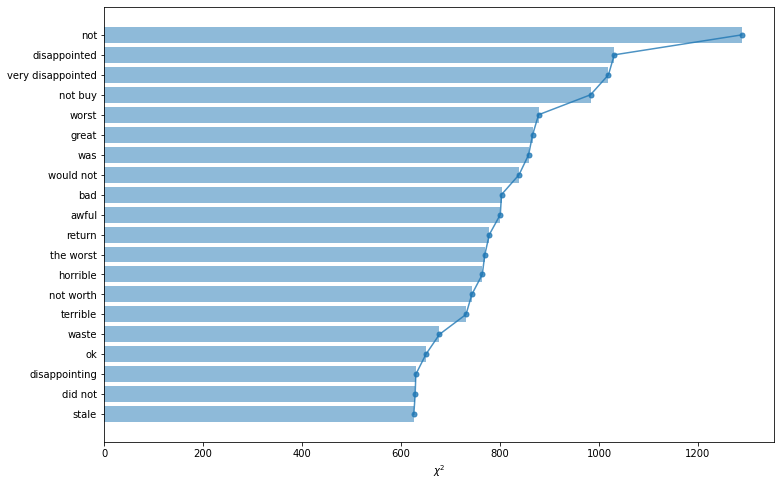

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,8))
scores = list(zip(tfidf.get_feature_names(), chi2score))
chi2 = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show();

**Интерпретация результата**

С помощью латентно-семантического анализа в коллекции отзывов были найдены наиболее часто встречающиеся слова, а также совершена классификация отзывов по тональности. Несмотря на превышающее число положительных отзывов, наиболее часто встречающимися словами стали not (не), disappointed (разочарован), very disappointed (очень разочарован), not buy (не куплю).

**Задания для самостоятельной работы**

С помощью LSA определите темы для документов:
1. doc1="Mango and starberries are sweet"
2. doc2="Science is her favorite subject"
3. doc3="Mathematics is an important subject"
4. doc4="Lemons and oranges are sour"
5. doc5="Algorithms and databases are tough"

Чтобы уменьшить размерность используйте усеченный SVD.
